In [1]:
#@title 1.3. IMPORT LIBRARY

import sys
sys.path.append('../utils')
from data_retrieval import credit_data_retrieval
from neural_net import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [2]:
df = credit_data_retrieval()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,Risk
0,2.766456,0.146949,-0.745131,-1.236478,0.176948,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,-1.191404,0.146949,0.949817,2.248194,-0.284901,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,1.183312,-1.383771,-0.416562,-0.738668,0.045495,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,0.831502,0.146949,1.634247,1.750384,0.130233,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,1.535122,0.146949,0.566664,0.256953,0.229637,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [14]:
type(df_train['Risk'].values)

numpy.ndarray

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
X_train, y_train = df_train.drop(columns='Risk'), df_train['Risk']
X_test, y_test = df_test.drop(columns='Risk'), df_test['Risk']
n = X_train.shape[1]

dataset = dict()
dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(X_train.values).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(y_train.values).type(torch.long).to(device)
dataset['test_input'] = torch.from_numpy(X_test.values).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(y_test.values).type(torch.long).to(device)

model = KAN(width=[n,4,2], grid=2, k=2, seed=42, device=device)
# model(dataset['train_input'])
# model.plot()

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
results['train_acc'][-1], results['test_acc'][-1]
# dataset['train_input'].cpu().detach().numpy().shape


checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 6.10e-01 | test_loss: 7.92e-01 | reg: 1.40e+02 | : 100%|█| 20/20 [00:05<00:00,  3.74it

saving model version 0.1


(0.83875, 0.73)

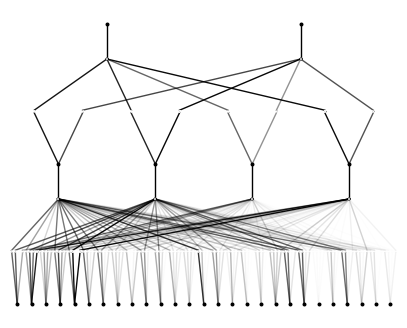

In [7]:
model.plot()

saving model version 0.2


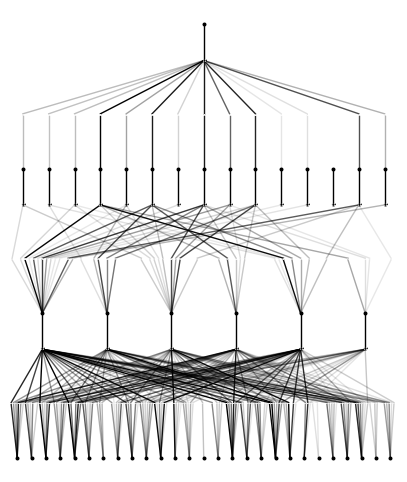

In [7]:
model = model.prune()
model.plot()

In [21]:
model(dataset['test_input']).cpu().detach().numpy()

array([[-1.01107352e+00,  3.85838446e+00],
       [ 3.59308585e+00, -4.46123161e+00],
       [-1.36093028e+00,  9.95447708e-01],
       [-5.51587751e+00,  6.39111521e+00],
       [-8.76937341e-01,  4.81969118e+00],
       [-1.21911361e+01,  1.22499814e+01],
       [-9.58899440e+00,  1.15255290e+01],
       [ 6.19450013e+00, -4.72277290e+00],
       [-5.76475536e+00,  6.40139525e+00],
       [-4.68930672e+00,  5.46850513e+00],
       [-2.88707026e+00, -1.67520448e+00],
       [ 8.13513555e+00, -6.68947102e+00],
       [-2.73681347e+00,  2.28023850e+00],
       [-2.72889102e+01, -1.65158418e+02],
       [-5.86358180e+00, -7.57535404e+00],
       [-2.32291417e+00,  2.86143714e+00],
       [-1.26752571e+00,  4.09772850e+00],
       [-5.72155920e+00,  3.79377888e+00],
       [-6.21145792e+00, -9.37733774e+00],
       [-2.68970906e+00,  3.18964926e+00],
       [-8.66597812e+00,  5.01350236e+00],
       [ 2.83452165e+00, -5.72633015e-01],
       [-4.86347942e+00,  3.20848530e+00],
       [-8.

In [15]:
pred = (model(dataset['test_input']).detach().cpu().resolve_conj().resolve_neg().numpy().flatten() >= 0.5).astype(int)
np.mean(pred == y_test)

0.555